## Vegetation Prediction using Sentinel-2

In this computing lab, you will create a simple machine learning model to predict vegetation percentage from Sentinel-2 imagery. The Copernicus Sentinel-2 mission is organized as a constellation of identical satellites in the same orbit: Sentinel-2A launched in 2015, Sentinel-2B launched in 2017, and Sentinel-2C launched in September of this year. Each satellite carries a multispectral imager with 13 spectral bands to measure our land and vegetation.

<img src=images/sentinel-2.jpg alt="Sentinel 2" width=500>

### 1. Learning Objectives
The goals of this computing lab are to:

1. Familiarize yourself with the structure of Sentinel-2 data
2. Visualize sample Sentinel-2 imagery and corresponding vegetation labels
3. Create a supervised machine learning pipeline using Pytorch Lightning and develop
    - dataloaders
    - data augmentations & transformations
    - (one or more) machine learning models
    - validation metrics

### 2. Data Exploration

Let's start by exploring the satellite data you will work with. You can download Sentinel-2 data directly from ```Copernicus``` (https://browser.dataspace.copernicus.eu/) or via platforms like ```Google Earth Engine``` (https://earthengine.google.com/). After creating an account, these platforms allow you to visualize and query EO data via their web interfaces, and provide support to download larger amounts of data via the command line or python scripts.
After downloading, it is usually a non-trivial amount of work to prepare EO data for machine learning purposes. Depending on your application, you might want to mask clouds, calculate weekly/monthly/seasonal summaries, adjust the range of pixel values etc. In addition, since EO images are often very large, you need to decide on a patching strategy to create machine learning ready data tiles that are large enough to contain relevant information, but small enough to fit into memory. 

##### 2.1. Area of Interest

Luckily, we have already downloaded and prepared ML-ready data for you! For this lab, we will focus on data from 2020 in Oxfordshire. To download the data, we create a wkt shape file of the county boundaries of Oxfordshire, and used ```geetiles``` (https://github.com/rramosp/geetiles) to download spatially aligned data tiles. We highly recommend looking into this tool, if you plan to use ```Google Earth Engine``` for your research. If you run the cell below, you can visualize what the spatial coverage of the tiles looks like. Each tile covers 1280 m x 1280 m

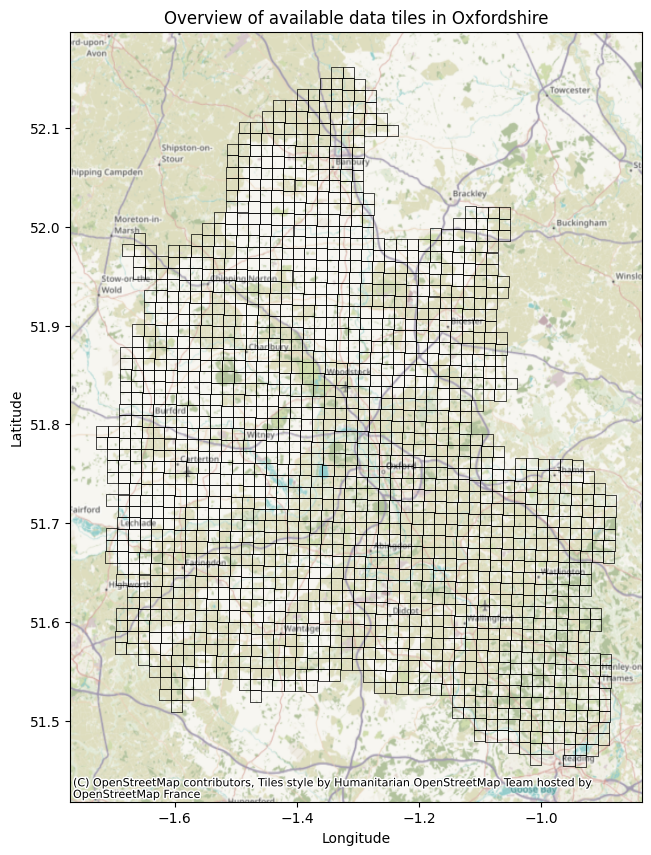

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Step 1: Load the GeoJSON file
geojson_file = "oxfordshire_partitions_aschips_2c696f57ca1c0.geojson"
gdf = gpd.read_file(geojson_file)

# Step 2: Plot the GeoDataFrame with no fill color and thin outlines
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

# Step 3: Add a basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Step 4: Customize the plot
ax.set_title("Overview of available data tiles in Oxfordshire")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

**Question**: How many data tiles are there in total?

##### 2.2. Data Variables & Visualization

Now that we have looked at our area of interest, let's investigate the data we will use, saved in **PATH/TO/DATA**. In this folder, you find Sentinel-2 imagery (sentinel2-2020) and vegetation labels (vegetation-2020). Each folder contains the same number of files, labeled with a unique identifier for each data tile shown above. 

In the cells below, pick a few identifiers and investigate what the data looks like.

In [6]:
import os
# Define data paths
base_path = 'oxfordshire_partitions_aschips_2c696f57ca1c0' # TODO: Remove data path
s2_path = os.path.join(base_path, 'sentinel2-2020')
veg_path = os.path.join(base_path, 'vegetation-2020')

# Pick a sample tile to investigate
tile_id = '0b18813cdd183' # TODO: Remove tile_id

In [7]:
import xarray as xr
import rasterio
# Define sentinel-2 file path
s2_filename = os.path.join(s2_path, f'{tile_id}.tif')

# Open sentinel-2 image using xarray and rasterio
s2_ds = xr.open_dataarray(s2_filename, engine="rasterio")
s2_ds

<xarray.DataArray 'band_data' (band: 40, y: 128, x: 128)>
[655360 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
  * x            (x) float64 -0.9402 -0.9401 -0.9399 ... -0.9222 -0.922 -0.9219
  * y            (y) float64 51.58 51.58 51.58 51.58 ... 51.57 51.57 51.57 51.57
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('winter_B2', 'winter_B3', 'winter_B4', 'winter_B5', 'win...

In [8]:
# Define vegetation file path
veg_filename = os.path.join(veg_path, f'{tile_id}.tif')

# Open vegetation data using xarray and rasterio
veg_ds = xr.open_dataarray(veg_filename, engine="rasterio")
veg_ds

<xarray.DataArray 'band_data' (band: 5, y: 128, x: 128)>
[81920 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5
  * x            (x) float64 -0.9402 -0.9401 -0.9399 ... -0.9222 -0.922 -0.9219
  * y            (y) float64 51.58 51.58 51.58 51.58 ... 51.57 51.57 51.57 51.57
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('Percent_Tree_Cover_2016', 'Percent_Tree_Cover_2017', 'P...

**Question**: What can you learn about the data and variables stored?

As you can see, the vegetation labels contain information on the percent tree cover for the years 2016 - 2020 (although we will only use data from 2020 today).
Our Sentinel-2 data contains seasonal summaries (Spring: Mar - May, Summer: Jun - Aug, Fall: Sep - Nov, Winter: Dec - Feb) for the high resolution (10-20 m) channels:

<img src=images/sentinel-2-bands.png alt="Sentinel 2 Bands" width=400>

**Question**: Which bands do you estimate are the most useful for vegetation prediction?

**Question**: Plot a few example tiles, and investigate what the data looks like. Can you create a proper RGB image of the Sentinel-2 data? What do you learn about the resolution of the datasets?

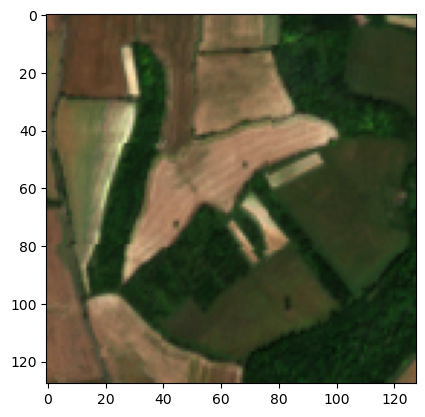

In [41]:
import numpy as np
# Select data variables
vars = ['summer_B4', 'summer_B3', 'summer_B2']

# Open dataset
ds = xr.open_dataarray(s2_filename, engine="rasterio")

# Select data variables
idx = [list(ds.long_name).index(v) for v in vars]
ds = ds.isel(band=idx)
# Convert data to numpy array
arr = ds.compute().values
# Normalize data between 0 and 1
arr = arr / np.nanmax(arr) 
# Change axis order for plotting
arr = np.moveaxis(arr, 0, -1)

plt.imshow(arr)

Text(0.5, 1.0, 'Percent Tree Cover 2020')

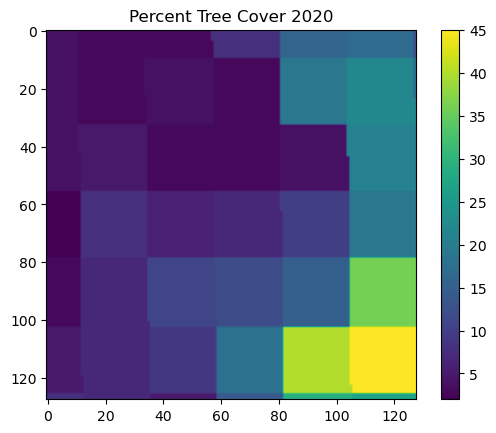

In [42]:
# Select data variables
vars = ['Percent_Tree_Cover_2020']

# Open dataset
ds = xr.open_dataarray(veg_filename, engine="rasterio")

# Select data variables
idx = [list(ds.long_name).index(v) for v in vars]
ds = ds.isel(band=idx)
# Convert data to numpy array
arr = ds.compute().values
# Change axis order for plotting
arr = np.moveaxis(arr, 0, -1)

plt.imshow(arr)
plt.colorbar()
plt.title('Percent Tree Cover 2020')

### 3. Pipeline Development

##### 3.1. Datasets & Dataloader

Now that we have investigated our data, we will develop our training pipeline starting with our dataloader. For this, we will first create a dataset that loads one image at a time, and feed this to a Pytorch dataloader that will create batches for training. We have started developing the code for you below, but a few lines are missing that you should fill in. Note, since the resolution of the vegetation labels is much coarser than the resolution of the Sentinel-2 imaergy, we will focus on predicting the **mean vegetation percentage** of each tile.

To make dataloading easier, we prepared a csv file for you (```oxfordshire_partitions_aschips_2c696f57ca1c0_splits.csv```), that contains information on which tiles should be used for training, validation, and testing. While there are different ways to split your data, we have opted to split our data by geographics bands (also using ```geetiles```). If you run the cell below, you can visualize what the data splits look like.

Text(180.40273933169354, 0.5, 'Latitude')

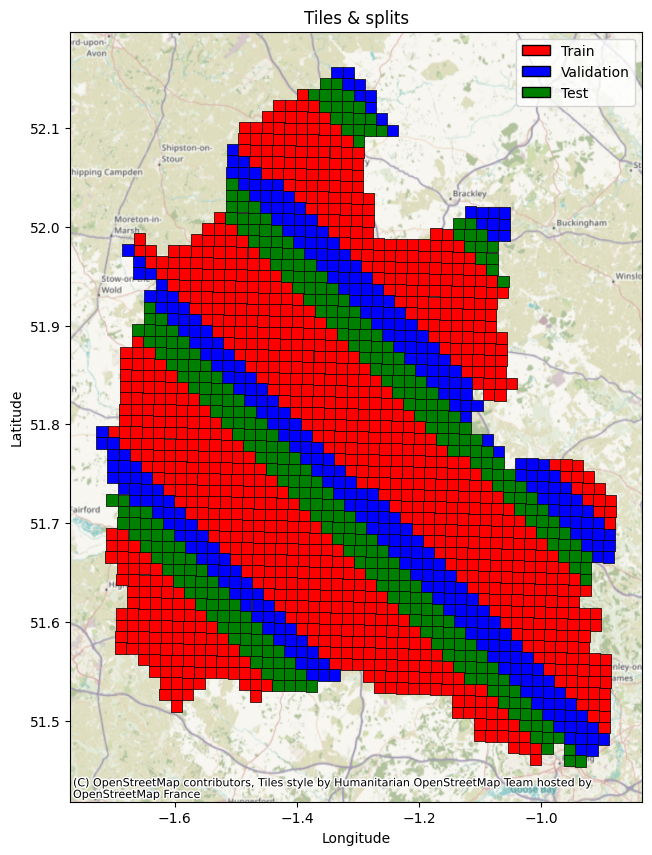

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.patches import Patch

# Load the GeoJSON file
geojson_file = "oxfordshire_partitions_aschips_2c696f57ca1c0.geojson"
gdf = gpd.read_file(geojson_file)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot each split separately
gdf[gdf['split'] == 'train'].plot(ax=ax, facecolor='red', edgecolor='black', linewidth=0.5)
gdf[gdf['split'] == 'val'].plot(ax=ax, facecolor='blue', edgecolor='black', linewidth=0.5)
gdf[gdf['split'] == 'test'].plot(ax=ax, facecolor='green', edgecolor='black', linewidth=0.5)

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Add a legend
# Create custom legend
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Train'),
    Patch(facecolor='blue', edgecolor='black', label='Validation'),
    Patch(facecolor='green', edgecolor='black', label='Test')
]
ax.legend(handles=legend_elements, loc='upper right')

# Customize the plot
ax.set_title("Tiles & splits")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

**Question**: What are some of the considerations when deciding on data splits?

In [58]:
from torch.utils.data import Dataset
from typing import List

class Dataset(Dataset):
    def __init__(
        self, 
        data_dir: str,
        files: List[str],
        seasons: List[str],
        bands: List[str],
        ):

        super().__init__()

        self.data_dir = data_dir
        self.files = files
        self.seasons = seasons
        self.bands = bands

        self.s2_path = os.path.join(data_dir, 'sentinel2-2020')
        self.veg_path = os.path.join(data_dir, 'vegetation-2020')

        self.s2_bands = [f"{season}_{band}" for season in seasons for band in bands]
        self.veg_bands = ['Percent_Tree_Cover_2020']

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # Compile file path
        s2_path = os.path.join(self.s2_path, f'{self.files[idx]}.tif')
        veg_path = os.path.join(self.veg_path, f'{self.files[idx]}.tif')

        # Open sentinel-2 image using xarray and rasterio
        s2_ds = xr.open_dataarray(s2_path, engine="rasterio")
        s2_ds = s2_ds.isel(band=[list(s2_ds.long_name).index(b) for b in self.s2_bands])
        s2_arr = s2_ds.compute().values

        # Normalize sentinel-2 data
        # Data is in image format with pixel values between [0, 255]
        s2_arr = s2_arr / 255.0

        # TODO: Add data augmentation

        # Open vegetation data using xarray and rasterio
        veg_ds = xr.open_dataarray(veg_path, engine="rasterio")
        veg_ds = veg_ds.isel(band=[list(veg_ds.long_name).index(b) for b in self.veg_bands])
        veg_arr = veg_ds.compute().values
        mean_veg = np.mean(veg_arr)

        return s2_arr, mean_veg

In [71]:
import pandas as pd
from lightning.pytorch import LightningDataModule
from torch.utils.data import DataLoader
from typing import List, Callable

class Dataloader(LightningDataModule):
    def __init__(
        self,
        data_dir: str,
        split_file: str,
        batch_size: int = 4,
        seasons: List[str]=['winter', 'spring', 'summer', 'fall'],
        bands: List[str]=['B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'], # Red-Edge, NIR, SWIR and visible bands
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.split_file = pd.read_csv(split_file)
        self.seasons = seasons
        self.bands = bands

        # Get list of files for each split
        self.train_files = self.split_file[self.split_file['split'] == 'train']['identifier'].tolist()
        self.val_files = self.split_file[self.split_file['split'] == 'val']['identifier'].tolist()
        self.test_files = self.split_file[self.split_file['split'] == 'test']['identifier'].tolist()

        self.train_dataset = Dataset(
            data_dir=self.data_dir,
            files=self.train_files,
            seasons=self.seasons,
            bands=self.bands
        )
        self.val_dataset = Dataset(
            data_dir=self.data_dir,
            files=self.val_files,
            seasons=self.seasons,
            bands=self.bands
        )
        self.test_dataset = Dataset(
            data_dir=self.data_dir,
            files=self.test_files,
            seasons=self.seasons,
            bands=self.bands
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            )

In [72]:
train_files = gdf[gdf['split'] == 'train']['identifier'].tolist()
val_files = gdf[gdf['split'] == 'val']['identifier'].tolist()
test_files = gdf[gdf['split'] == 'test']['identifier'].tolist()

split_file = 'oxfordshire_partitions_aschips_2c696f57ca1c0_splits.csv'

dataset = Dataloader(
    data_dir=base_path,
    split_file=split_file,
    seasons=['winter', 'spring', 'summer', 'fall'],
    bands=['B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
)

In [78]:
test = next(iter(dataset.train_dataloader()))

In [82]:
test[1].shape

torch.Size([4])